<a href="https://colab.research.google.com/github/wilmerwasv/TelecomX_Latam_WilmerSubero/blob/main/TelecomX_Latam_WilmerSubero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Extracción de datos**

In [1]:
import pandas as pd
import requests

url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()


##**Normalizar el JSON (aplanar si hay estructuras anidadas)**



In [2]:
df = pd.json_normalize(data)
df.columns = [col.replace('.', '_') for col in df.columns]
df.head(2)

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4


### **Conoce el conjunto de dato**

In [3]:
#revisando los tipos de datos de las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_SeniorCitizen     7267 non-null   int64  
 4   customer_Partner           7267 non-null   object 
 5   customer_Dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_PhoneService         7267 non-null   object 
 8   phone_MultipleLines        7267 non-null   object 
 9   internet_InternetService   7267 non-null   object 
 10  internet_OnlineSecurity    7267 non-null   object 
 11  internet_OnlineBackup      7267 non-null   object 
 12  internet_DeviceProtection  7267 non-null   object 
 13  internet_TechSupport       7267 non-null   objec

# **Comprobación de incoherencias en los datos y Manejo de inconsistencias**

In [4]:
df['account_Charges_Total'] = pd.to_numeric(df['account_Charges_Total'], errors='coerce')

In [5]:
#Cambiado a float columna account_Charges_Monthly
print(df['account_Charges_Total'].dtype)  # Debe mostrar: float64
print(df['account_Charges_Total'].isna().sum())  # Cuántos quedaron como NaN



float64
11


In [6]:
#transformando a bool las columnas que tienes yes/no
# Función para convertir columnas con solo Yes/No a bool
def yes_no_to_bool(df):
    for col in df.columns:
        uniques = df[col].dropna().unique()
        if set(uniques).issubset({'Yes', 'No'}):
            df[col] = df[col].map({'Yes': True, 'No': False})
    return df

# Aplicar al DataFrame
df = yes_no_to_bool(df)

# Verificar
for col in df.columns:
    if df[col].dtype == bool:
        print(f"Columna '{col}' convertida a bool")


Columna 'customer_Partner' convertida a bool
Columna 'customer_Dependents' convertida a bool
Columna 'phone_PhoneService' convertida a bool
Columna 'account_PaperlessBilling' convertida a bool


In [7]:
#  ver los valores únicos
print(pd.unique(df['Churn']))
print(pd.unique(df.customer_gender))



['No' 'Yes' '']
['Female' 'Male']


In [8]:
def informe_calidad_datos(df, max_valores=5):
    resumen = []

    for col in df.columns:
        tipo = df[col].dtype
        nulos = df[col].isnull().mean() * 100
        unicos = df[col].nunique(dropna=False)

        muestra_valores = df[col].dropna().astype(str).str.strip().value_counts().head(max_valores).to_dict()

        posibles_errores = []

        if tipo in ['object', 'category']:
            # Buscar espacios al inicio/final
            if df[col].astype(str).str.startswith(' ').any() or df[col].astype(str).str.endswith(' ').any():
                posibles_errores.append("Espacios al inicio o final")
            # Buscar diferencias de capitalización
            valores = df[col].dropna().unique()
            valores_lower = set([str(v).lower() for v in valores])
            if len(valores) != len(valores_lower):
                posibles_errores.append("Mayúsculas/minúsculas inconsistentes")
            # Valores vacíos o en blanco
            if df[col].astype(str).str.strip().isin(['', 'nan']).any():
                posibles_errores.append("Valores vacíos o blancos")

        resumen.append({
            "columna": col,
            "tipo": tipo,
            "nulos (%)": round(nulos, 2),
            "valores únicos": unicos,
            "muestra de valores": muestra_valores,
            "posibles errores": ", ".join(posibles_errores) if posibles_errores else "Ninguno"
        })

    return pd.DataFrame(resumen).sort_values(by="nulos (%)", ascending=False).reset_index(drop=True)

# 🔍 Ejecutamos sobre tu DataFrame
informe = informe_calidad_datos(df)
pd.set_option('display.max_colwidth', None)  # Para ver todos los valores
display(informe)


,columna,tipo,nulos (%),valores únicos,muestra de valores,posibles errores
0,account_Charges_Total,float64,0.15,6531,"{'20.2': 11, '19.75': 9, '19.9': 9, '19.55': 9, '20.05': 8}",Ninguno
1,Churn,object,0.00,3,"{'No': 5174, 'Yes': 1869, '': 224}",Valores vacíos o blancos
2,customer_gender,object,0.00,2,"{'Male': 3675, 'Female': 3592}",Ninguno
3,customer_SeniorCitizen,int64,0.00,2,"{'0': 6085, '1': 1182}",Ninguno
4,customerID,object,0.00,7267,"{'9995-HOTOH': 1, '0002-ORFBO': 1, '0003-MKNFE': 1, '9970-QBCDA': 1, '9968-FFVVH': 1}",Ninguno
5,customer_Partner,bool,0.00,2,"{'False': 3749, 'True': 3518}",Ninguno
6,customer_Dependents,bool,0.00,2,"{'False': 5086, 'True': 2181}",Ninguno
7,phone_PhoneService,bool,0.00,2,"{'True': 6560, 'False': 707}",Ninguno
8,customer_tenure,int64,0.00,73,"{'1': 634, '72': 369, '2': 246, '3': 207, '4': 185}",Ninguno
9,internet_InternetService,object,0.00,3,"{'Fiber optic': 3198, 'DSL': 2488, 'No': 1581}",Ninguno


In [9]:
import numpy as np

# 1. Reemplazar cadenas vacías o solo espacios por NaN en todo el DataFrame
df = df.replace(r'^\s*$', np.nan, regex=True)

# 2. Volver a revisar cuántos NaN hay en Churn
print("Churn antes de limpiar:", df['Churn'].isna().sum(), "filas con NaN")

# 3. Decidir qué hacer con esos NaN de Churn:
#    - Opción A: eliminarlos si no son muchos
df = df.dropna(subset=['Churn'])

#    - Opción B: imputarlos como 'No' (suponiendo que ausencia = no se fue)
# df['Churn'] = df['Churn'].fillna(False)

# 4. Validar que no queden espacios ni mayúsculas inconsistentes en categóricas
for col in df.select_dtypes(include=['object', 'category']):
    df[col] = df[col].astype(str).str.strip()

# 5. Confirmar estado final
print(df['Churn'].value_counts(dropna=False))
print(df.info())


Churn antes de limpiar: 224 filas con NaN
Churn
No     5174
Yes    1869
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer_gender            7043 non-null   object 
 3   customer_SeniorCitizen     7043 non-null   int64  
 4   customer_Partner           7043 non-null   bool   
 5   customer_Dependents        7043 non-null   bool   
 6   customer_tenure            7043 non-null   int64  
 7   phone_PhoneService         7043 non-null   bool   
 8   phone_MultipleLines        7043 non-null   object 
 9   internet_InternetService   7043 non-null   object 
 10  internet_OnlineSecurity    7043 non-null   object 
 11  internet_OnlineBackup      7043 non-null   object 
 12  internet_De

In [10]:
print(pd.unique(df['Churn']))

['No' 'Yes']


#**Columna de cuentas diarias**

In [11]:
# Crear columna "Cuentas_Diarias" dividiendo la facturación mensual entre días promedio por mes
df['Cuentas_Diarias'] = df['account_Charges_Monthly'] / 30.44

# (Opcional) Redondear a dos decimales
df['Cuentas_Diarias'] = df['Cuentas_Diarias'].round(2)

# Verificamos la nueva columna
print(df[['account_Charges_Monthly', 'Cuentas_Diarias']].head())


   account_Charges_Monthly  Cuentas_Diarias
0                     65.6             2.16
1                     59.9             1.97
2                     73.9             2.43
3                     98.0             3.22
4                     83.9             2.76


#**Estandarización y transformación de datos (opcional)**

In [12]:
# Diccionario de traducción
traducir_columnas = {
    'customerID': 'ID_Cliente',
    'Churn': 'Evasion',
    'customer_gender': 'Genero',
    'customer_SeniorCitizen': 'EsAdultoMayor',
    'customer_Partner': 'TienePareja',
    'customer_Dependents': 'TieneDependientes',
    'customer_tenure': 'AntigüedadMeses',
    'phone_PhoneService': 'ServicioTelefonico',
    'phone_MultipleLines': 'MultiplesLineas',
    'internet_InternetService': 'TipoInternet',
    'internet_OnlineSecurity': 'SeguridadEnLinea',
    'internet_OnlineBackup': 'RespaldoEnLinea',
    'internet_DeviceProtection': 'ProteccionEquipos',
    'internet_TechSupport': 'SoporteTecnico',
    'internet_StreamingTV': 'TVStreaming',
    'internet_StreamingMovies': 'PeliculasStreaming',
    'account_Contract': 'TipoContrato',
    'account_PaperlessBilling': 'FacturaDigital',
    'account_PaymentMethod': 'MetodoPago',
    'account_Charges_Monthly': 'CargosMensuales',
    'account_Charges_Total': 'CargosTotales',
    'Cuentas_Diarias': 'CargosDiarios'
}

# Aplicar renombramiento
df.rename(columns=traducir_columnas, inplace=True)

# Verificamos resultado
df.head()


,ID_Cliente,Evasion,Genero,EsAdultoMayor,TienePareja,TieneDependientes,AntigüedadMeses,ServicioTelefonico,MultiplesLineas,TipoInternet,...,ProteccionEquipos,SoporteTecnico,TVStreaming,PeliculasStreaming,TipoContrato,FacturaDigital,MetodoPago,CargosMensuales,CargosTotales,CargosDiarios
0,0002-ORFBO,No,Female,0,True,True,9,True,No,DSL,...,No,Yes,Yes,No,One year,True,Mailed check,65.6,593.30,2.16
1,0003-MKNFE,No,Male,0,False,False,9,True,Yes,DSL,...,No,No,No,Yes,Month-to-month,False,Mailed check,59.9,542.40,1.97
2,0004-TLHLJ,Yes,Male,0,False,False,4,True,No,Fiber optic,...,Yes,No,No,No,Month-to-month,True,Electronic check,73.9,280.85,2.43
3,0011-IGKFF,Yes,Male,1,True,False,13,True,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,True,Electronic check,98.0,1237.85,3.22
4,0013-EXCHZ,Yes,Female,1,True,False,3,True,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,True,Mailed check,83.9,267.40,2.76


In [13]:
# Columnas con valores 'Yes'/'No' (excluyendo los que tienen 'No internet service' u otros casos especiales)
columnas_yes_no = [
    'Evasion',
    'SeguridadEnLinea',
    'RespaldoEnLinea',
    'ProteccionEquipos',
    'SoporteTecnico',
    'TVStreaming',
    'PeliculasStreaming',
    'MultiplesLineas'
]

# Convertimos 'Yes' a True y 'No' a False
for col in columnas_yes_no:
    df[col] = df[col].map({'Yes': True, 'No': False})
# Reemplazar valores adicionales por False
servicios_con_no_service = [
    'SeguridadEnLinea',
    'RespaldoEnLinea',
    'ProteccionEquipos',
    'SoporteTecnico',
    'TVStreaming',
    'PeliculasStreaming',
    'MultiplesLineas'
]

for col in servicios_con_no_service:
    df[col] = df[col].replace({'Yes': True, 'No': False, 'No internet service': False, 'No phone service': False})


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Cliente          7043 non-null   object 
 1   Evasion             7043 non-null   bool   
 2   Genero              7043 non-null   object 
 3   EsAdultoMayor       7043 non-null   int64  
 4   TienePareja         7043 non-null   bool   
 5   TieneDependientes   7043 non-null   bool   
 6   AntigüedadMeses     7043 non-null   int64  
 7   ServicioTelefonico  7043 non-null   bool   
 8   MultiplesLineas     6361 non-null   object 
 9   TipoInternet        7043 non-null   object 
 10  SeguridadEnLinea    5517 non-null   object 
 11  RespaldoEnLinea     5517 non-null   object 
 12  ProteccionEquipos   5517 non-null   object 
 13  SoporteTecnico      5517 non-null   object 
 14  TVStreaming         5517 non-null   object 
 15  PeliculasStreaming  5517 non-null   object 
 16  TipoContrat

#**Análisis Descriptivo**

In [15]:
import pandas as pd

# Análisis descriptivo de columnas numéricas
descripcion_numericas = df.describe().T  # transpuesta para mejor visualización
descripcion_numericas["mediana"] = df[descripcion_numericas.index].median()
descripcion_numericas["nulos (%)"] = df[descripcion_numericas.index].isnull().mean() * 100

# Mostrar principales estadísticas
print("📊 Análisis descriptivo numérico:\n")
print(descripcion_numericas[[
    "count", "mean", "std", "min", "25%", "50%", "mediana", "75%", "max", "nulos (%)"
]])

# Análisis de variables categóricas relevantes
columnas_categoricas = df.select_dtypes(include="object").columns.tolist()

print("\n🔤 Distribución de valores categóricos:\n")
for col in columnas_categoricas:
    print(f"\n📌 {col}:\n")
    print(df[col].value_counts(dropna=False))
    print("-" * 40)


📊 Análisis descriptivo numérico:

                  count         mean          std    min     25%       50%  \
EsAdultoMayor    7043.0     0.162147     0.368612   0.00    0.00     0.000   
AntigüedadMeses  7043.0    32.371149    24.559481   0.00    9.00    29.000   
CargosMensuales  7043.0    64.761692    30.090047  18.25   35.50    70.350   
CargosTotales    7032.0  2283.300441  2266.771362  18.80  401.45  1397.475   
CargosDiarios    7043.0     2.127521     0.988435   0.60    1.17     2.310   

                  mediana        75%      max  nulos (%)  
EsAdultoMayor       0.000     0.0000     1.00   0.000000  
AntigüedadMeses    29.000    55.0000    72.00   0.000000  
CargosMensuales    70.350    89.8500   118.75   0.000000  
CargosTotales    1397.475  3794.7375  8684.80   0.156183  
CargosDiarios       2.310     2.9500     3.90   0.000000  

🔤 Distribución de valores categóricos:


📌 ID_Cliente:

ID_Cliente
9995-HOTOH    1
0002-ORFBO    1
0003-MKNFE    1
9970-QBCDA    1
9968-FFVVH 

#**Distribución de evasión**

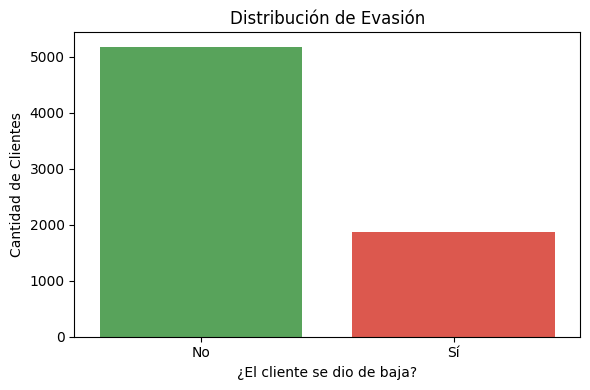

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapeamos los valores booleanos para visualización directamente en una copia
df_viz = df.copy()
df_viz["Evasion_str"] = df_viz["Evasion"].map({True: "Sí", False: "No"})

# Gráfico de conteo simple (sin leyenda, con etiquetas modificadas)
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df_viz, x="Evasion_str", hue="Evasion_str", palette=["#4CAF50", "#F44336"], legend=False)

plt.title("Distribución de Evasión")
plt.xlabel("¿El cliente se dio de baja?")
plt.ylabel("Cantidad de Clientes")

# Eliminar la leyenda
ax.get_legend().remove() if ax.get_legend() else None

plt.tight_layout()
plt.show()


#**Recuento de evasión por variables categóricas**

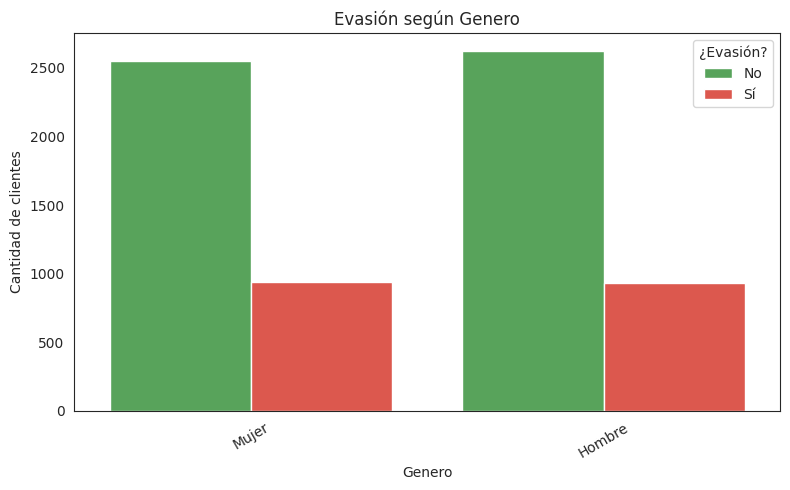

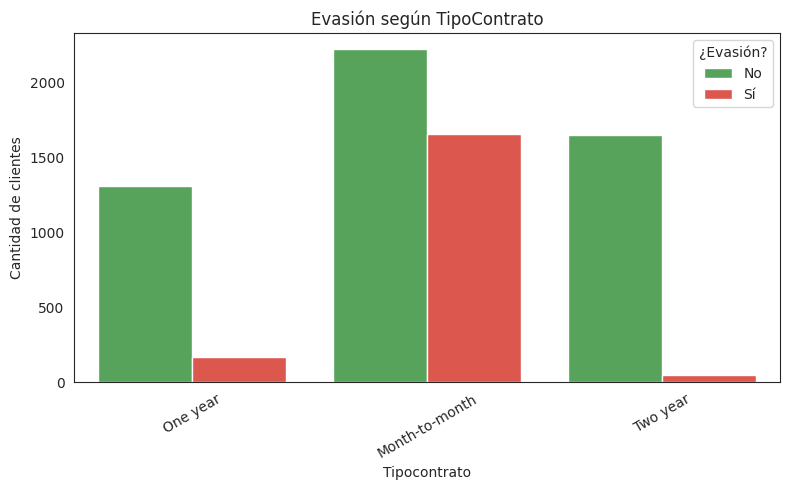

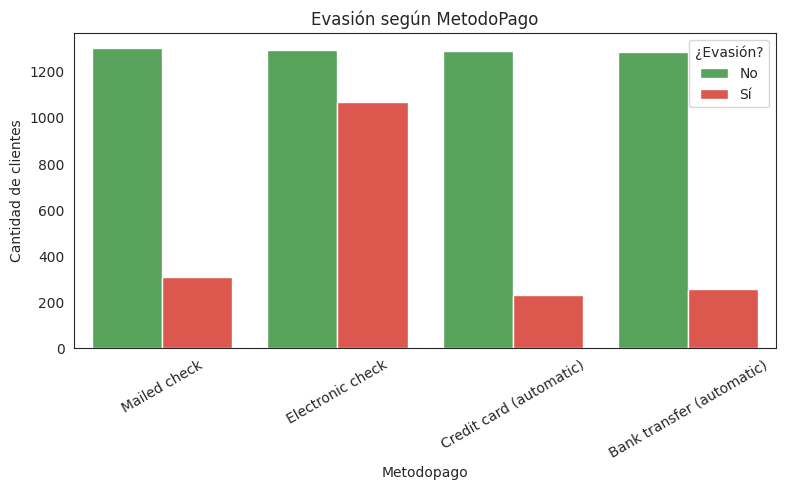

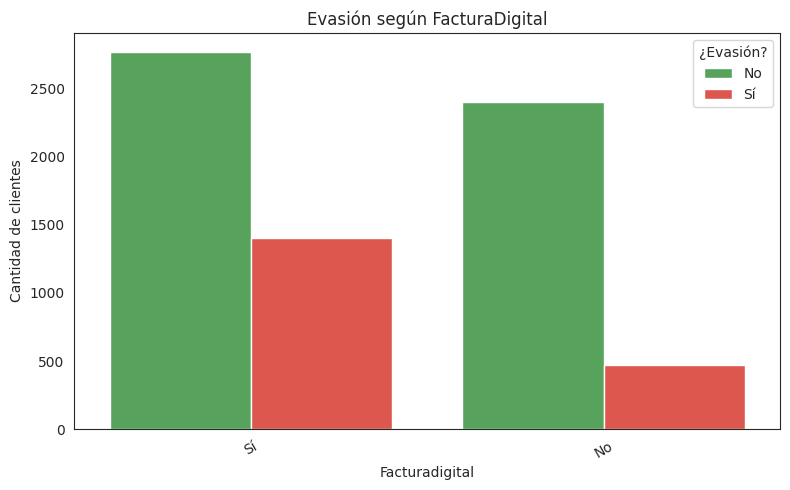

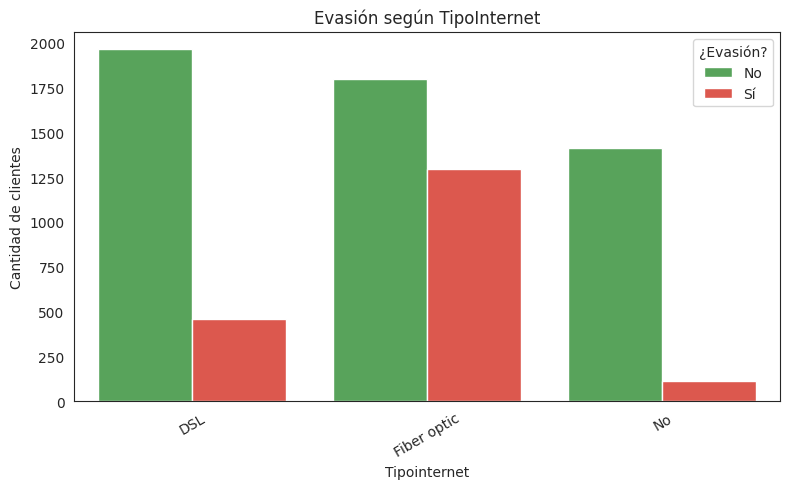

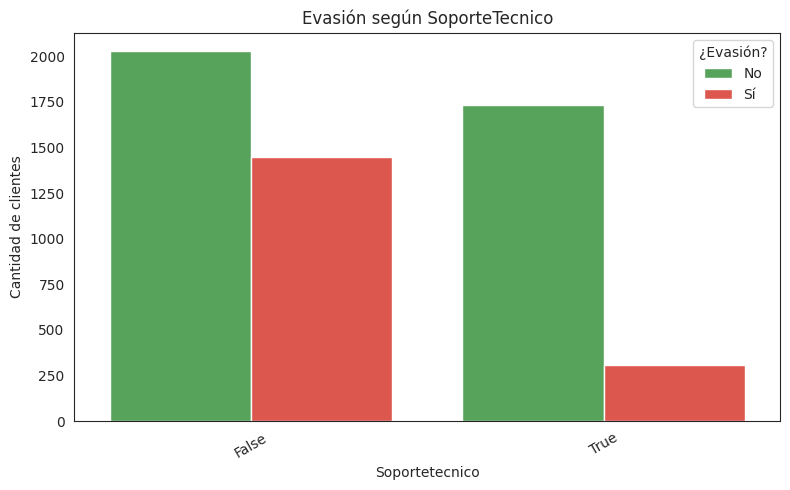

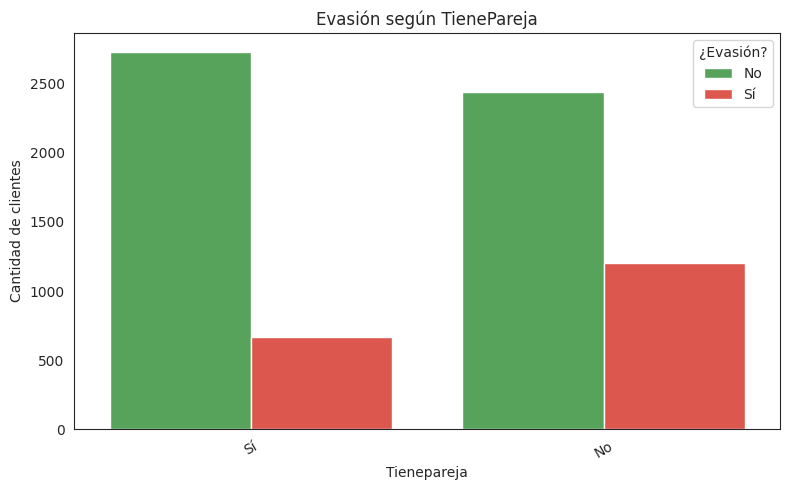

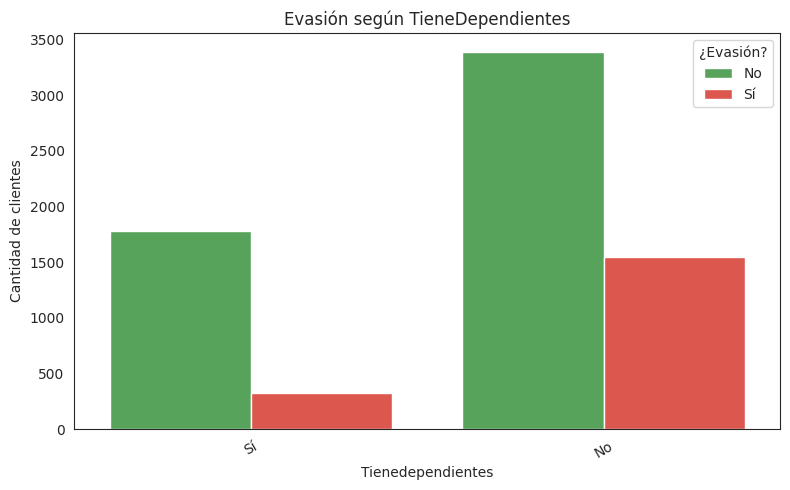

In [17]:

# Copia para visualización y mapear valores booleanos y de género a etiquetas en español
df_viz = df.copy()

# Mapeo personalizado para cada columna que puede tener True/False o valores específicos
mapeos = {
    "Evasion": {True: "Sí", False: "No"},
    "Genero": {"Male": "Hombre", "Female": "Mujer"},
    "TienePareja": {True: "Sí", False: "No"},
    "TieneDependientes": {True: "Sí", False: "No"},
    "FacturaDigital": {True: "Sí", False: "No"}
}

# Aplicamos los mapeos en la copia para visualización
for col, mapa in mapeos.items():
    if col in df_viz.columns:
        df_viz[col] = df_viz[col].map(mapa).fillna(df_viz[col])

# Variables categóricas en español a analizar
variables_categoricas = [
    "Genero",
    "TipoContrato",
    "MetodoPago",
    "FacturaDigital",
    "TipoInternet",
    "SoporteTecnico",
    "TienePareja",
    "TieneDependientes"
]

sns.set_style("white")  # Quitar cuadrícula de fondo

for columna in variables_categoricas:
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(
        data=df_viz,
        x=columna,
        hue="Evasion",
        palette=["#4CAF50", "#F44336"]
    )
    plt.title(f"Evasión según {columna}")
    plt.xlabel(columna.replace("_", " ").capitalize())
    plt.ylabel("Cantidad de clientes")
    plt.xticks(rotation=30)
    plt.legend(title="¿Evasión?")
    plt.tight_layout()
    plt.show()


#**Conteo de evasión por variables numéricas**

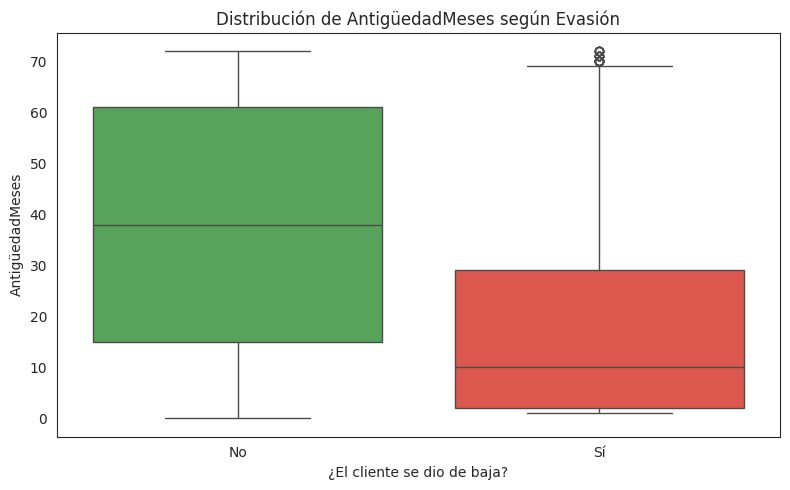

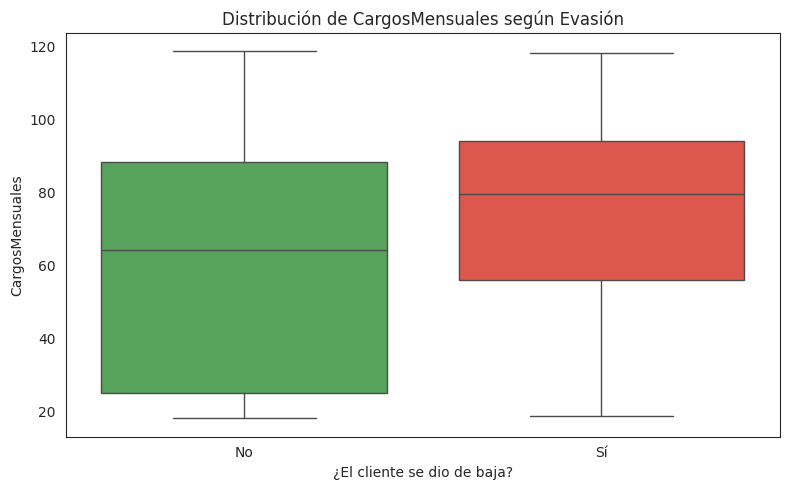

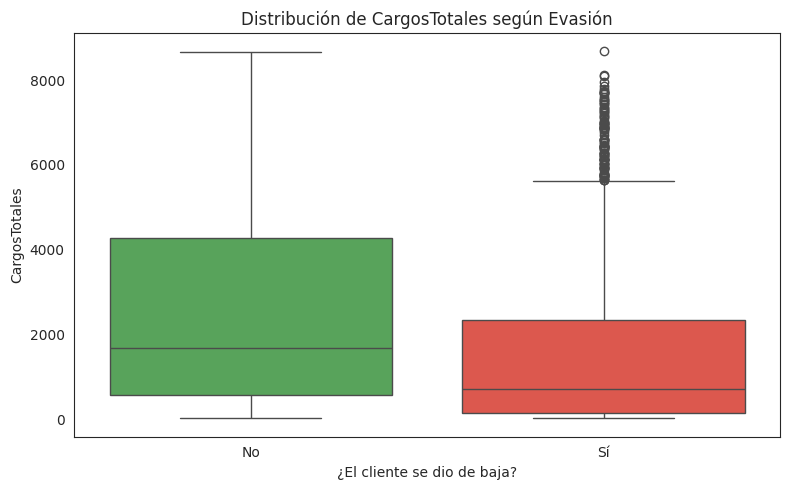

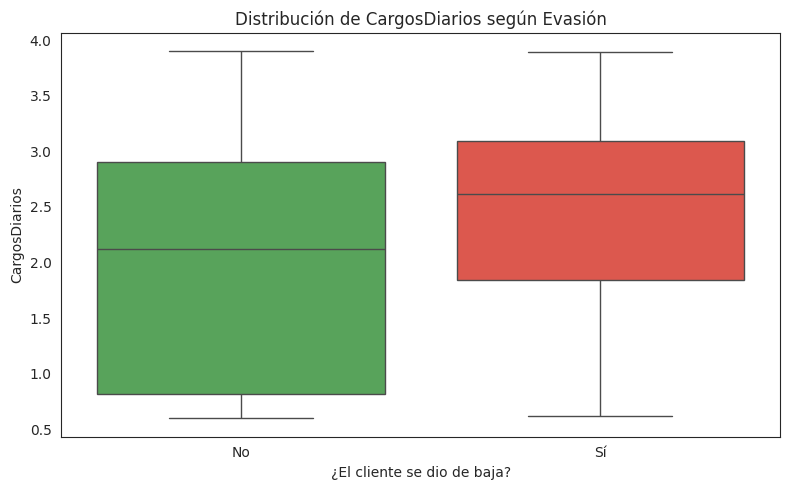

In [18]:
# Copia y mapeo para etiquetas claras en 'Evasión'
df_viz = df.copy()
df_viz["Evasión"] = df_viz["Evasion"].map({True: "Sí", False: "No"})

# Variables numéricas a analizar (en español)
vars_numericas = [
    "AntigüedadMeses",
    "CargosMensuales",
    "CargosTotales",
    "CargosDiarios"
]

# Visualización con boxplots
for var in vars_numericas:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="Evasión", y=var, hue="Evasión", data=df_viz, palette={"Sí": "#F44336", "No": "#4CAF50"}, legend=False)
    plt.title(f"Distribución de {var} según Evasión")
    plt.xlabel("¿El cliente se dio de baja?")
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()


# Informe de Análisis de Evasión de Clientes (Churn)

## 🔹 Introducción

Este informe presenta un análisis exploratorio de datos sobre la evasión de clientes (Churn) de TelecomX. El objetivo es identificar los factores y patrones clave asociados con la decisión de un cliente de cancelar su servicio, con el fin de desarrollar estrategias efectivas para reducir la tasa de evasión y mejorar la retención de clientes.

## 🔹 Limpieza y Tratamiento de Datos

Se inició el proceso descargando los datos de clientes desde una URL en formato JSON utilizando las bibliotecas `requests` y `pandas`. El JSON, que presentaba una estructura anidada, fue aplanado utilizando `pd.json_normalize` para crear un DataFrame tabular (`df`).

Se realizaron las siguientes tareas de limpieza y tratamiento:
- Conversión de la columna `account.Charges.Total` a tipo numérico, manejando valores no válidos con `errors='coerce'`.
- Identificación y manejo de valores vacíos o en blanco en la columna `Churn`, los cuales fueron tratados como valores nulos (`NaN`) y posteriormente eliminados del DataFrame.
- Conversión de columnas con valores 'Yes'/'No' a tipo booleano para facilitar el análisis.
- Renombramiento de columnas a español para mayor claridad (`df.rename`).
- Creación de una nueva columna `CargosDiarios` a partir de los cargos mensuales.

## 🔹 Análisis Exploratorio de Datos

Se realizó un análisis descriptivo para comprender la distribución y estadísticas de las variables numéricas (`df.describe().T`) y la distribución de valores en las variables categóricas (`df.value_counts`).

Las visualizaciones clave generadas incluyen:

### Distribución de Evasión

Un gráfico de barras mostró la proporción de clientes que evadieron (`Sí`) frente a los que no (`No`), indicando la magnitud del problema de evasión.


### Recuento de Evasión por Variables Categóricas

Se generaron gráficos de barras para analizar la relación entre la evasión y variables como Género, Tipo de Contrato, Método de Pago, Factura Digital, Tipo de Internet, Soporte Técnico, Tiene Pareja y Tiene Dependientes. Estos gráficos revelaron diferencias notables en las tasas de evasión según las categorías de estas variables.


### Conteo de Evasión por Variables Numéricas

Se utilizaron boxplots para visualizar la distribución de variables numéricas (Antigüedad en Meses, Cargos Mensuales, Cargos Totales, Cargos Diarios) para los grupos de clientes que evadieron y los que no. Estos gráficos permitieron identificar si las métricas numéricas difieren significativamente entre los dos grupos.



## 🔹 Conclusiones e Insights

El análisis de los datos y las visualizaciones ha revelado varios factores fuertemente asociados con la evasión de clientes:

- **Antigüedad:** Los clientes con menor antigüedad son significativamente más propensos a evadir.
- **Cargos Mensuales/Diarios:** Clientes con cargos mensuales y diarios más altos muestran una mayor tasa de evasión.
- **Tipo de Contrato:** Los contratos mes a mes tienen una tasa de evasión mucho mayor que los contratos a largo plazo (uno o dos años).
- **Método de Pago:** El pago con cheque electrónico está asociado a una mayor evasión.
- **Servicio de Internet:** Los clientes con servicio de fibra óptica tienen una tasa de evasión más alta.
- **Soporte Técnico:** La ausencia de soporte técnico incrementa la probabilidad de evasión.
- **Factura Digital:** La facturación digital parece estar correlacionada con una mayor evasión.
- **Factores menos influyentes:** El género, tener pareja y tener dependientes mostraron una menor asociación con la evasión en comparación con las otras variables analizadas.

En resumen, los clientes con mayor riesgo de evasión son aquellos que son **nuevos**, tienen **altos cargos mensuales**, con contratos **mes a mes**, que usan **cheque electrónico** como método de pago, tienen servicio de **fibra óptica** y **no tienen soporte técnico**.

## 🔹 Recomendaciones

Basado en los insights obtenidos, se proponen las siguientes recomendaciones estratégicas para reducir la evasión:

1.  **Programas de Retención Temprana:** Enfocar esfuerzos en los clientes con poca antigüedad, ofreciendo incentivos o un seguimiento especial para asegurar una buena experiencia inicial.
2.  **Optimización de Precios/Planes:** Revisar la estructura de cargos mensuales, especialmente para los planes de fibra óptica, para asegurar que sean competitivos y percibidos como justos por los clientes.
3.  **Fomentar Contratos a Largo Plazo:** Ofrecer descuentos o beneficios atractivos para incentivar a los clientes a migrar de contratos mes a mes a contratos de uno o dos años.
4.  **Análisis y Mejora del Método de Pago Electrónico:** Investigar si existen problemas específicos asociados con el método de pago electrónico que puedan estar contribuyendo a la insatisfacción del cliente.
5.  **Fortalecer el Soporte Técnico:** Promocionar activamente y mejorar la calidad del servicio de soporte técnico, ya que su ausencia es un fuerte predictor de evasión. Considerar incluir soporte técnico como parte estándar de ciertos planes.
6.  **Experiencia con Fibra Óptica:** Investigar las causas detrás de la alta evasión en clientes de fibra óptica. Podría ser necesario mejorar la estabilidad del servicio, la atención al cliente para este segmento, o gestionar mejor las expectativas iniciales.
7.  **Revisar el Proceso de Factura Digital:** Aunque menos influyente, podría valer la pena investigar si hay algún problema de usabilidad o comunicación asociado con la facturación digital que contribuya a la evasión.

Implementar estas recomendaciones, enfocándose en los segmentos de mayor riesgo y las variables más influyentes, puede ayudar a TelecomX a reducir su tasa de evasión y mejorar la lealtad de sus clientes.